In [1]:
%matplotlib notebook
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy

sys.path.insert(0, os.path.abspath('../'))
from src.lib import centroids as centutils

plt.rcParams['figure.figsize'] = [10, 10]

<IPython.core.display.Javascript object>


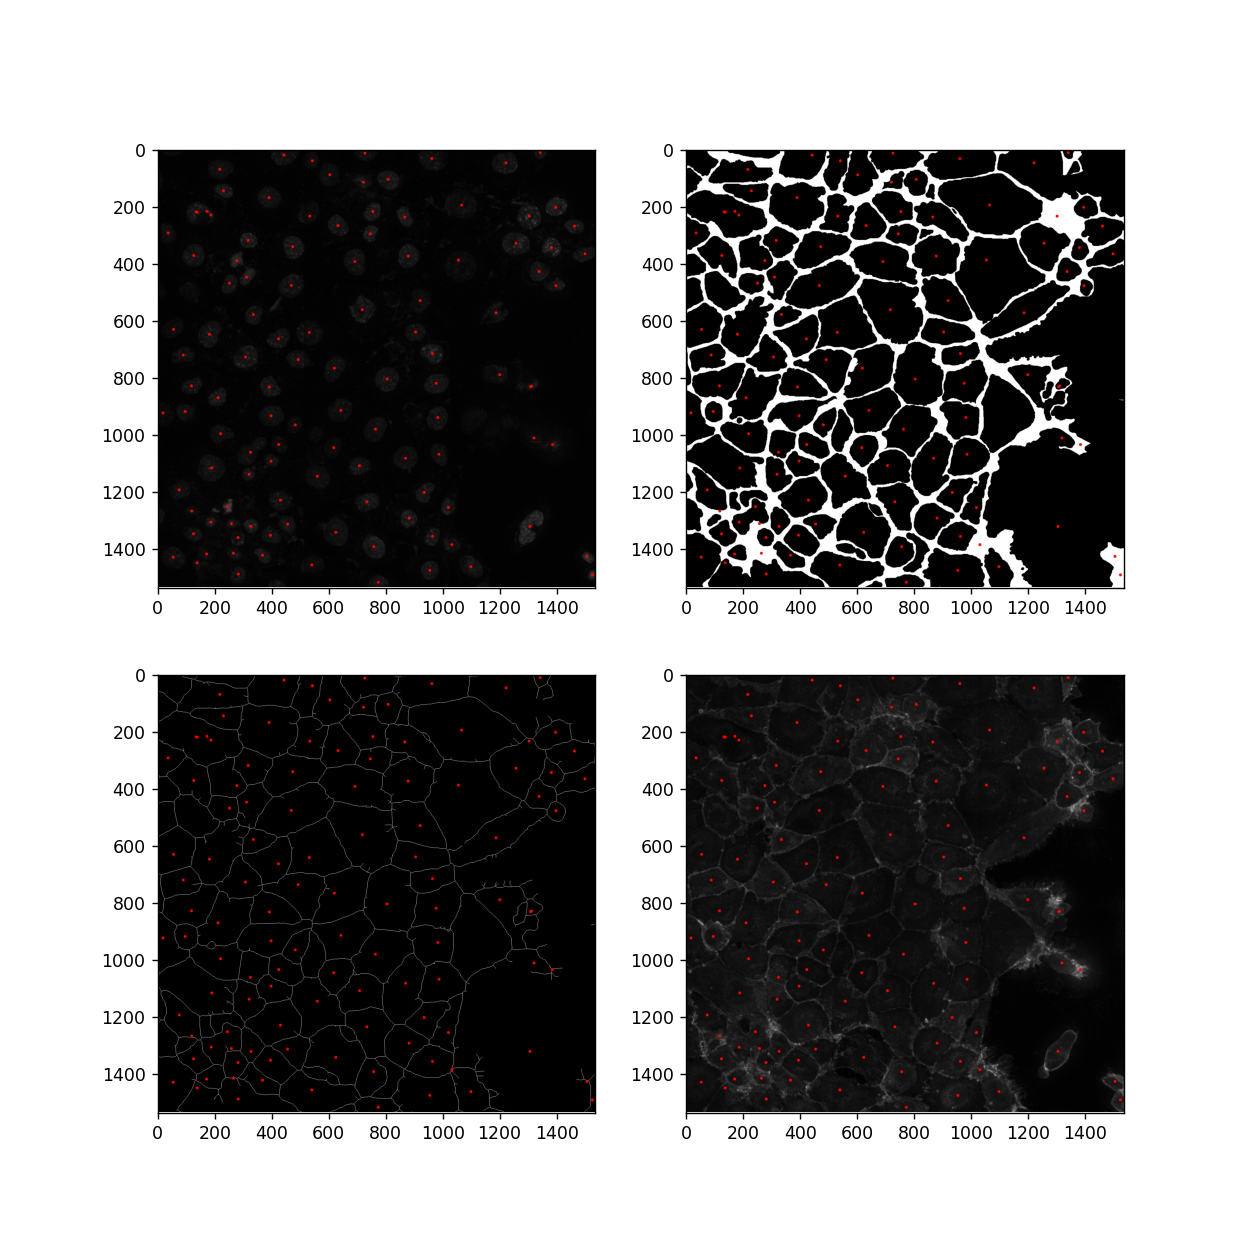

In [2]:
nuclei_path = '../data/first/Nuclei/AKT1_B1_CAn.tif'
jbin_path = '../data/first/Segmented/AKT1_B1_CAj-BI.tif'
jsk_path = '../data/first/Skeletonized/AKT1_B1_CAj-SK.tif'
j_path = '../data/first/Original/AKT1_B1_CAj.tif'

nuclei_img = cv2.imread(nuclei_path)
jbin_img = cv2.imread(jbin_path)
jsk_img = cv2.imread(jsk_path)
j_img = cv2.imread(j_path)

centroids = centutils.get_nuclei_centroids(nuclei_img)

nuclei_centroids = nuclei_img.copy()
jbin_centroids = jbin_img.copy()
jsk_centroids = jsk_img.copy()
j_centroids = j_img.copy()


for x, y in centroids:
    cv2.circle(nuclei_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jbin_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jsk_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(j_centroids, (x, y), 5, (255, 0, 0), -1)

    
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(nuclei_centroids)
ax[0,1].imshow(jbin_centroids)
ax[1,0].imshow(jsk_centroids)
ax[1,1].imshow(j_centroids)

<IPython.core.display.Javascript object>


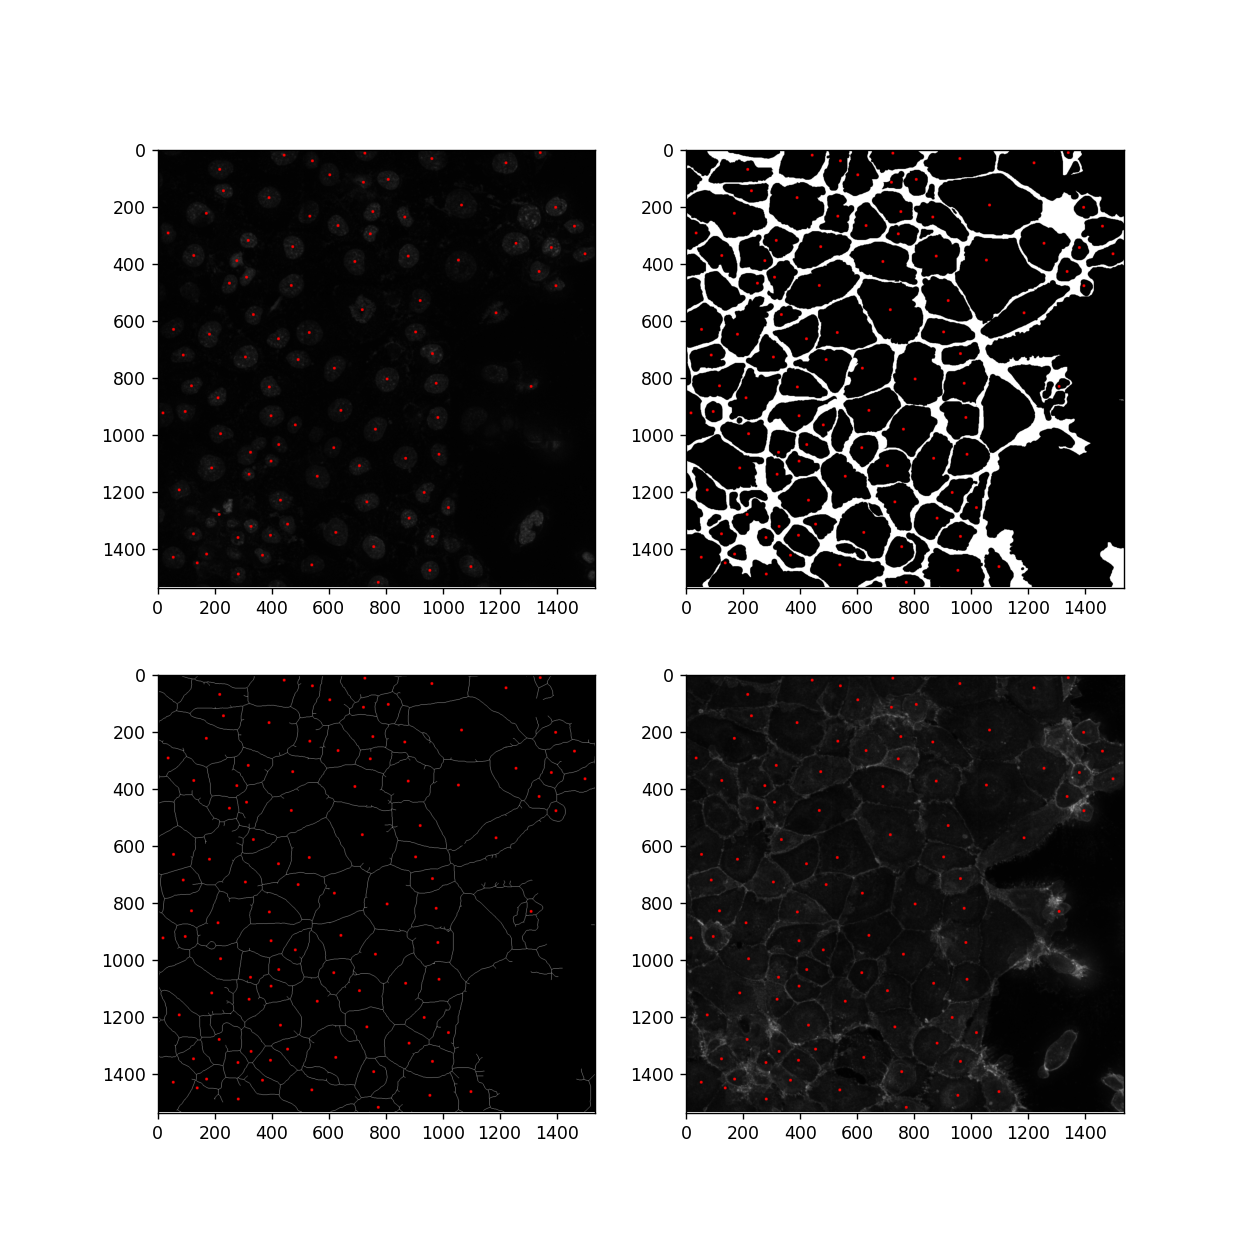

In [3]:
centroids = centutils.clean_centroids(centroids, jbin_img)
centroids, moments = centutils.get_moments_cells(centroids, jbin_img)

nuclei_centroids = nuclei_img.copy()
jbin_centroids = jbin_img.copy()
jsk_centroids = jsk_img.copy()
j_centroids = j_img.copy()


for x, y in centroids:
    cv2.circle(nuclei_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jbin_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jsk_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(j_centroids, (x, y), 5, (255, 0, 0), -1)

    
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(nuclei_centroids)
ax[0,1].imshow(jbin_centroids)
ax[1,0].imshow(jsk_centroids)
ax[1,1].imshow(j_centroids)

# Std filter

Using the generic_filter with np.std is too slow, so we are using another implementation (from https://nickc1.github.io/python,/matlab/2016/05/17/Standard-Deviation-(Filters)-in-Matlab-and-Python.html). Nevertheless, we are going to compare the results from both implementations.

In [4]:
from scipy.ndimage.filters import generic_filter, uniform_filter

a = np.arange(100).reshape(10,10).astype(float)
result_generic = generic_filter(a, np.std, size=7)

In [5]:
def window_stdev(img, window_size):
    X = img.astype(float)
    r,c = X.shape
    c1 = uniform_filter(X, window_size, mode='reflect')
    c2 = uniform_filter(X*X, window_size, mode='reflect')
    variance = c2 - c1*c1
    variance = np.where(variance < 0, 0, variance)
    
    return np.sqrt(variance)
    
result_custom = window_stdev(a, 7)

In [6]:
difference = result_generic - result_custom
difference.max(), difference.min()

(9.592326932761353e-14, -1.580957587066223e-13)

Every value is very small, close to zero, so both implementations are equivalent (and the difference is because of rounding errors)

We are going to apply this filter over an image

In [7]:
j_img_gray = cv2.cvtColor(j_img, cv2.COLOR_BGR2GRAY)
filtered = window_stdev(j_img_gray, 7)

<IPython.core.display.Javascript object>


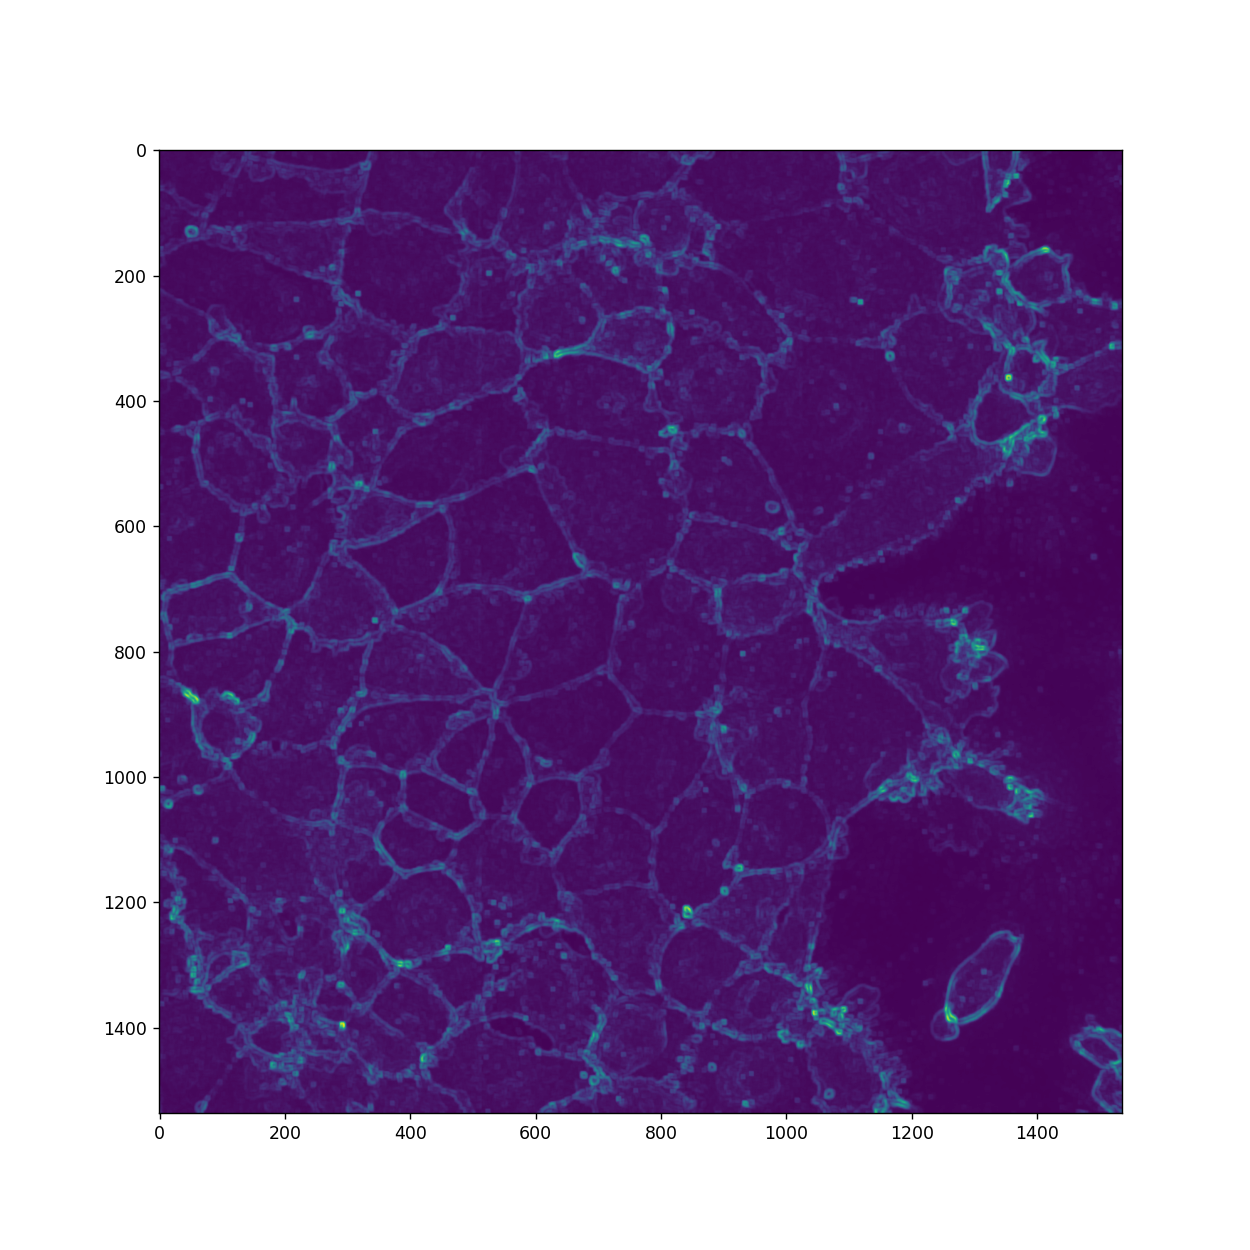

In [8]:
plt.imshow(filtered)

It works, but we need to compute this filter only on the cell-cell junction! So we are gonna use a mask.

In [9]:
def get_mask(j_img, jbin_img):
    j_img_gray =  cv2.cvtColor(j_img, cv2.COLOR_BGR2GRAY) 
    jbin_img_gray =  cv2.cvtColor(jbin_img, cv2.COLOR_BGR2GRAY)    
    mask = j_img_gray.copy()
    mask[jbin_img_gray == 0] = 0
    return mask

<IPython.core.display.Javascript object>


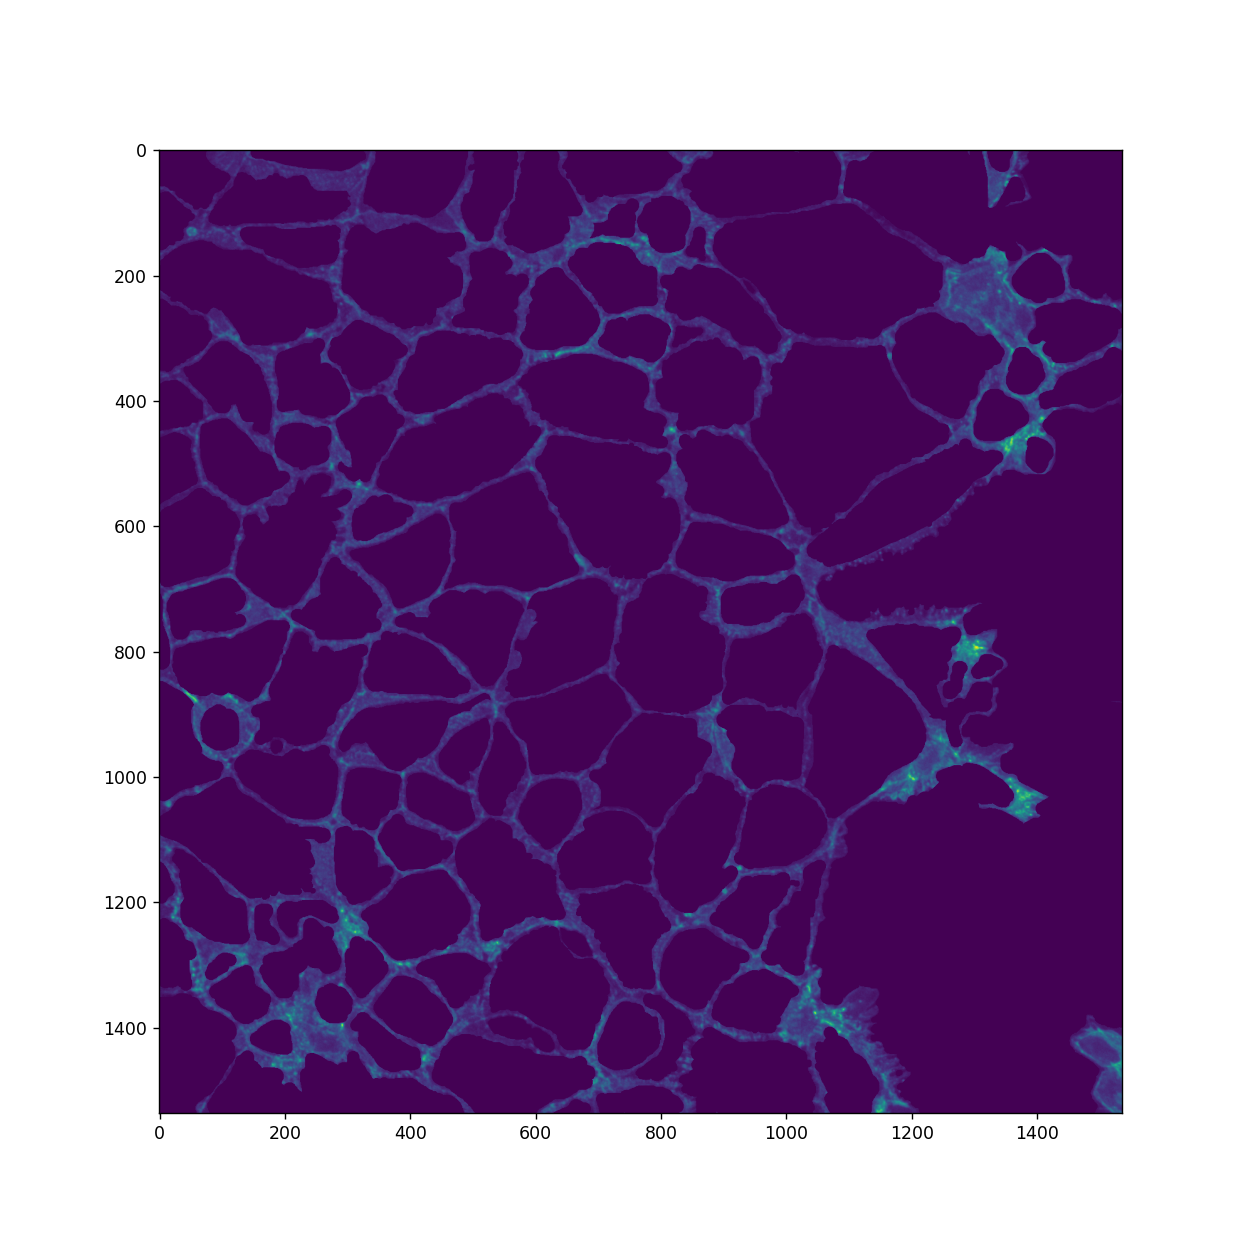

In [11]:
mask = get_mask(j_img, jbin_img)
plt.imshow(mask)

In [12]:
filtered_mask = window_stdev(mask, 7)

<IPython.core.display.Javascript object>


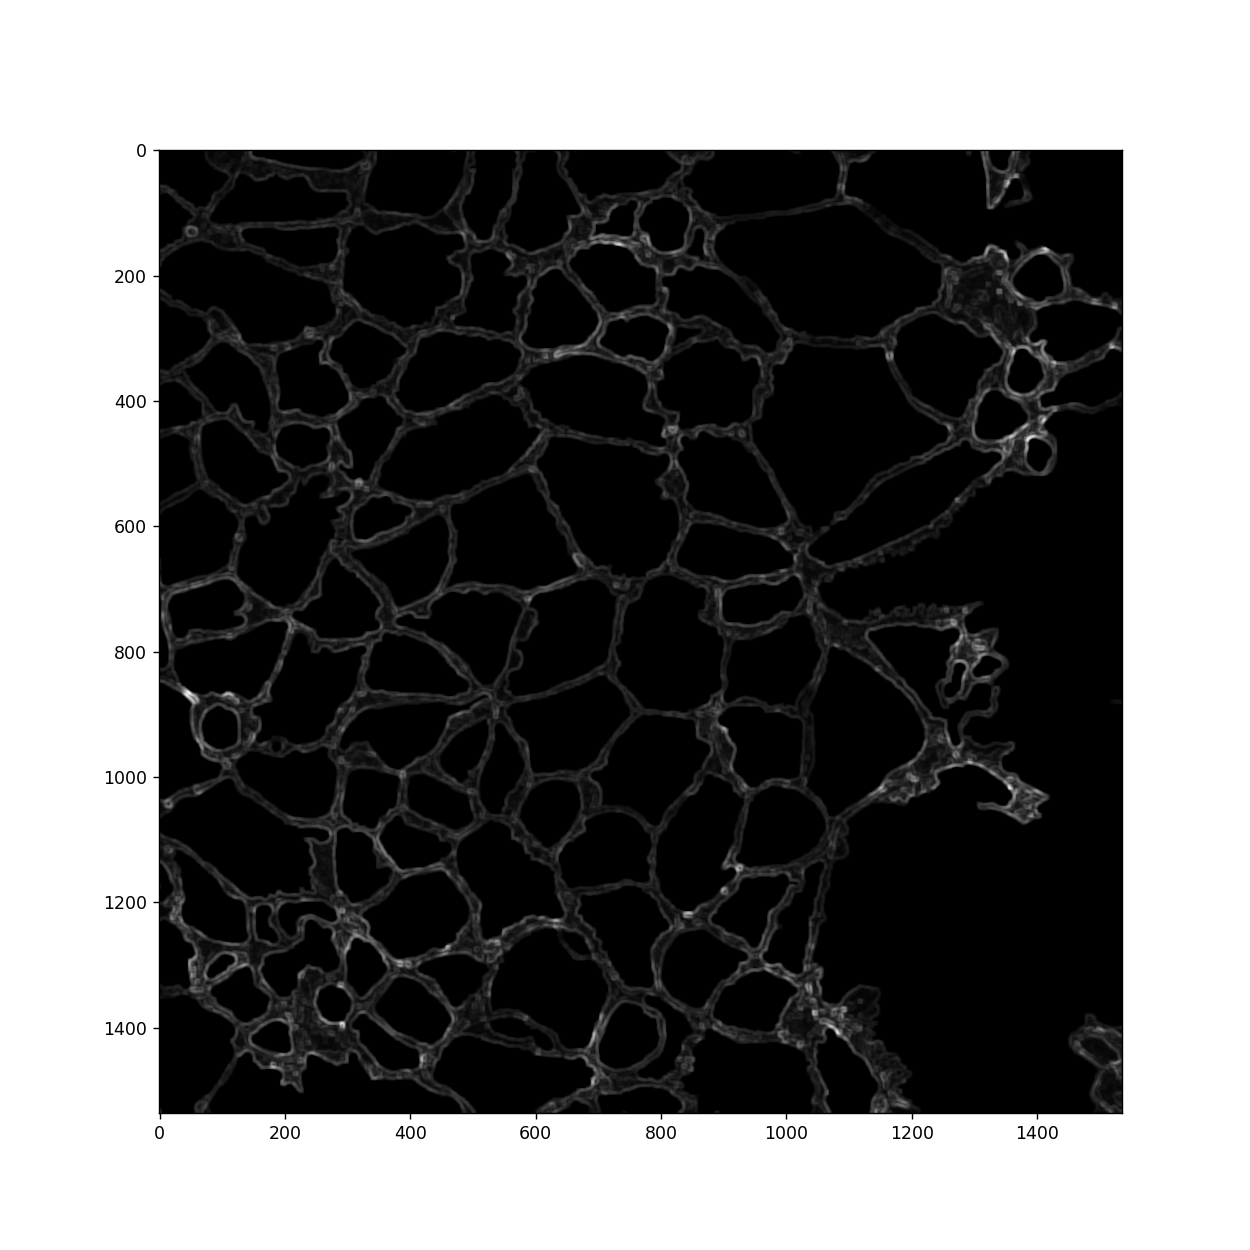

In [13]:
plt.imshow(filtered_mask, cmap='gray')

But that's not how it should work! we must get apply the filter first and then mask the image.

<IPython.core.display.Javascript object>


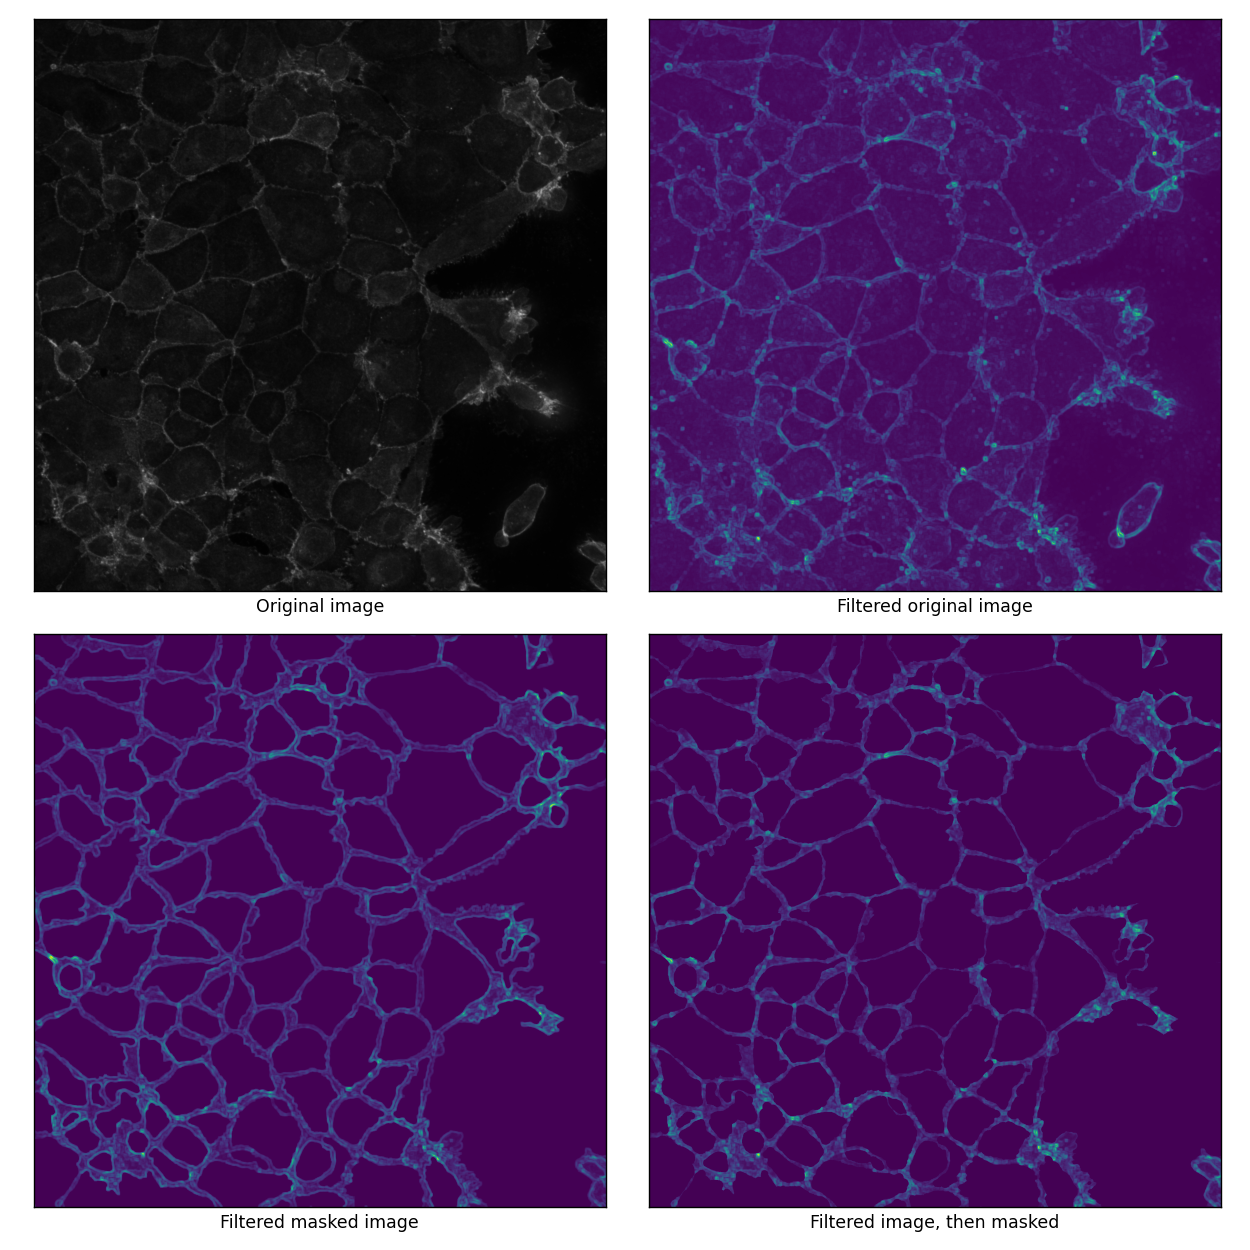

In [15]:
filtered = window_stdev(j_img_gray, 7)
j_bin_img_gray =  cv2.cvtColor(jbin_img, cv2.COLOR_BGR2GRAY) 
filtered_copy = filtered.copy()
filtered_copy[j_bin_img_gray == 0] = 0

fig, axes = plt.subplots(2,2)
axes[0, 0].imshow(j_img)
axes[0, 0].set_xlabel('Original image')
axes[0, 0].set_yticks([])
axes[0, 0].set_xticks([])

axes[0, 1].imshow(filtered)
axes[0, 1].set_xlabel('Filtered original image')
axes[0, 1].set_yticks([])
axes[0, 1].set_xticks([])

axes[1, 0].imshow(filtered_mask)
axes[1, 0].set_xlabel('Filtered masked image')
axes[1, 0].set_yticks([])
axes[1, 0].set_xticks([])

axes[1, 1].imshow(filtered_copy)
axes[1, 1].set_xlabel('Filtered image, then masked')
axes[1, 1].set_yticks([])
axes[1, 1].set_xticks([])


plt.tight_layout()

Now, we get the aggregated results of this filter: the mean and std (yes, the std of the local stds, it's weird)

In [16]:
def std_filter_statistics(img):
    filtered = window_stdev(img, window_size=7)
    non_zero = filtered[np.where(filtered != 0)]
    return non_zero.mean(), non_zero.std()

In [17]:
std_filter_statistics(mask)

(4.285949341074712, 6.243885979246015)

# Entropy filter

In [18]:
filteredent = entropy(mask, np.ones((7,7)))

<IPython.core.display.Javascript object>


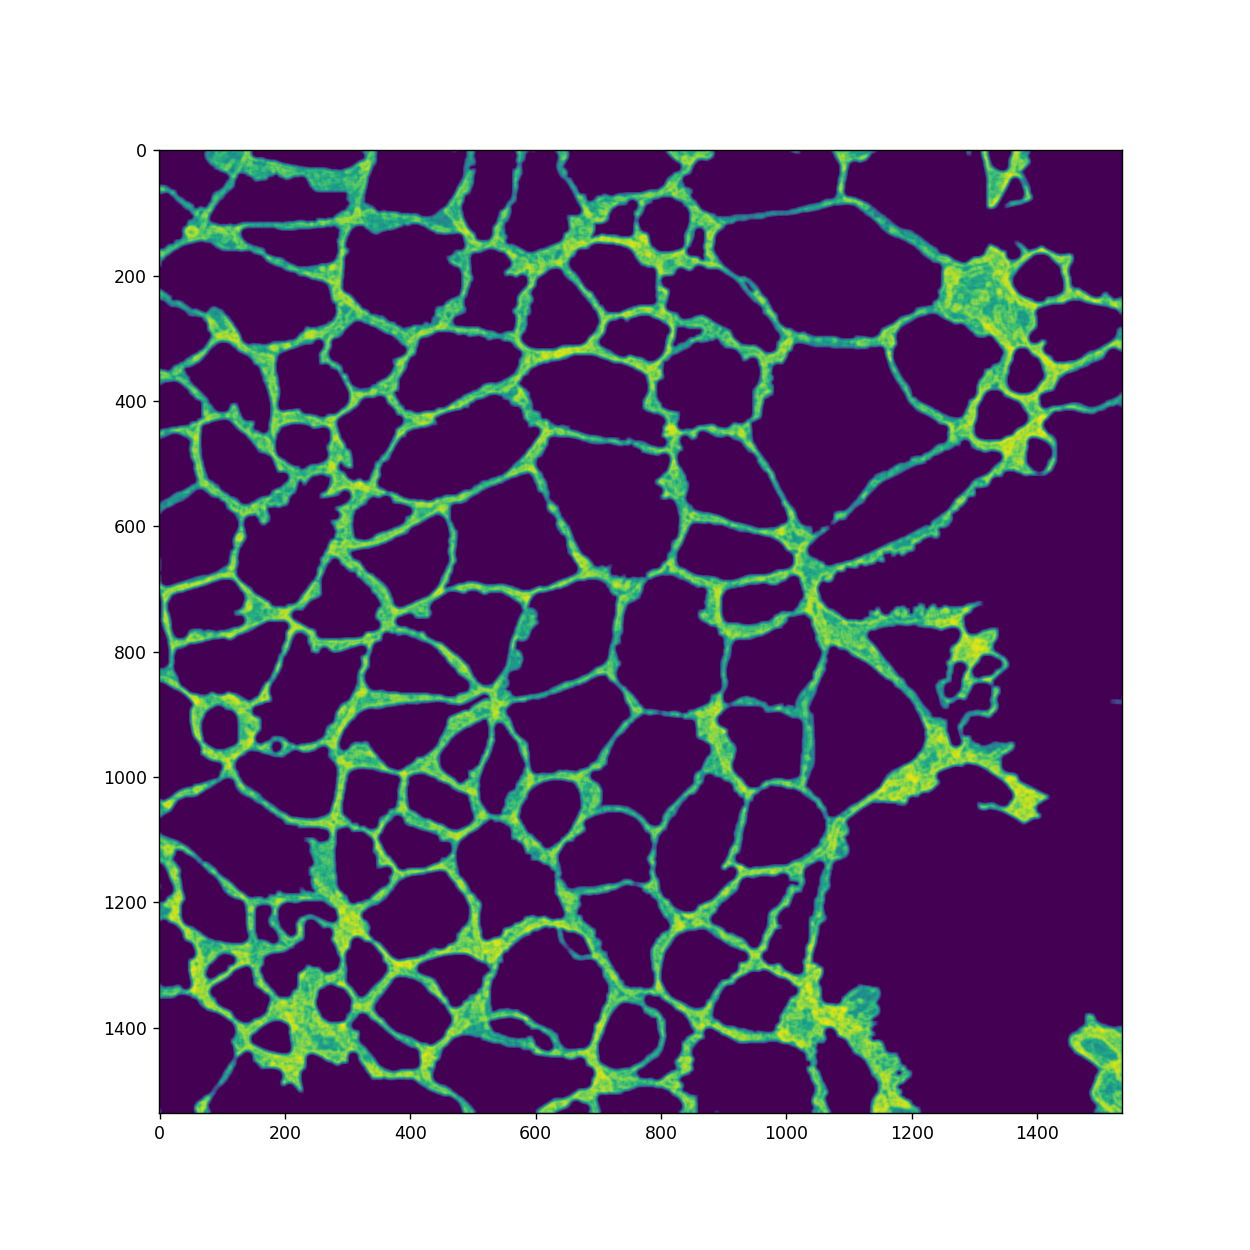

In [20]:
plt.imshow(filteredent)

In [ ]:
def entropy_filter_statistics(img):
    filtered = entropy(img, np.ones((7,7)))
    non_zero = filtered[np.where(filtered != 0)]
    return non_zero.mean(), non_zero.std()

In [ ]:
entropy_filter_statistics(mask)

# Structure tensor based texture

In [ ]:
def gaussian_kernel(dimension_x, dimension_y, sigma_x, sigma_y):
    x = cv2.getGaussianKernel(dimension_x, sigma_x)
    y = cv2.getGaussianKernel(dimension_y, sigma_y)
    kernel = x.dot(y.T)
    return kernel

In [ ]:
filter_size = 15
sigma = filter_size / 3
kernel = gaussian_kernel(filter_size, filter_size, sigma, sigma)

In [ ]:
plt.imshow(kernel)

In [ ]:
from scipy.ndimage import convolve1d

In [ ]:
j_img_gray =  cv2.cvtColor(j_img, cv2.COLOR_BGR2GRAY) 
gx = convolve1d(j_img_gray, np.array([-1,0,1]), mode='nearest', axis=1)
gy = convolve1d(j_img_gray, np.array([-1,0,1]), mode='nearest', axis=0)

In [ ]:
fig, ax = plt.subplots(2, figsize=(5,10))
ax[0].imshow(gx)
ax[1].imshow(gy)

In [ ]:
gx = gx[1:-1, 1:-1]
gy = gy[1:-1, 1:-1]

In [ ]:
gx_squared = gx*gx
gy_squared = gy*gy
gx_gy = gx*gy

In [ ]:
fig, ax = plt.subplots(3, figsize=(5,15))
ax[0].imshow(gx_squared)
ax[1].imshow(gy_squared)
ax[2].imshow(gx_gy)

In [ ]:
from scipy.signal import convolve2d

In [ ]:
gx_squared_f = convolve2d(gx_squared, kernel, mode='full', boundary='symm')
gy_squared_f = convolve2d(gy_squared, kernel, mode='full', boundary='symm')
gx_gy_f = convolve2d(gx_gy, kernel, mode='full', boundary='symm')

# Gabor filters

In [ ]:
n_rows, n_cols = (0.25 * np.array(j_img_gray.shape[:2])).astype(int)
img_resized = cv2.resize(j_img_gray, (n_rows, n_cols))

In [ ]:
wavelength_min = 4 / np.sqrt(2)
wavelength_max = np.sqrt(n_rows**2 + n_cols**2)
n = int(np.floor(np.log2(wavelength_max / wavelength_min)))    
wavelengths = 2** np.arange(0, n - 1) * wavelength_min
delta_theta = 45
orientations = np.arange(0, 180 - delta_theta + 1, delta_theta)
